In [1]:
#imports
import pandas as pd
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import KFold, train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.style.use('ggplot')

In [2]:
df=pd.read_csv("../../documents/mlFiles/adult.csv")
display(df.shape)
display(df.columns)
display_side_by_side(df.head(10),df.tail(10))

(32561, 15)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

NameError: name 'display_side_by_side' is not defined

Convert columns to the preferred data types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


<h3>Cleaning the data</h3>
<p>particularly the object columns since they are more likely to contain invalid entries</p>

In [4]:
# def findInvalid(colName):
    
#     print(colName,': ',df[colName].unique())
#     print(colName,':',len(df[df[colName]=='?']),'\n')
def getVals(colName):
    return df[colName].unique()

def countNulls(colName):
    return len(df[df[colName]=='?'])

colnames=df.select_dtypes(include=['object']).columns #include='object' error 'include and exclude must both be non-string sequences'

invalidDf=pd.DataFrame()#dataframe to store null counts of all columns
invalidDf['objectColumns']=colnames
invalidDf['values']=invalidDf['objectColumns'].apply(getVals)
invalidDf['null count']=invalidDf['objectColumns'].apply(countNulls)

"""
with apply, parameters are not needed when the method is called (although the method may specify one)
This is because the parameters are assumed to be the values of the dataframe that uses apply
"""
display(invalidDf)


,objectColumns,values,null count
0,workclass,"[?, Private, State-gov, Federal-gov, Self-emp-...",1836
1,education,"[HS-grad, Some-college, 7th-8th, 10th, Doctora...",0
2,marital.status,"[Widowed, Divorced, Separated, Never-married, ...",0
3,occupation,"[?, Exec-managerial, Machine-op-inspct, Prof-s...",1843
4,relationship,"[Not-in-family, Unmarried, Own-child, Other-re...",0
5,race,"[White, Black, Asian-Pac-Islander, Other, Amer...",0
6,sex,"[Female, Male]",0
7,native.country,"[United-States, ?, Mexico, Greece, Vietnam, Ch...",583
8,income,"[<=50K, >50K]",0


In [97]:
""" 
Beware of group_by. it returns a group object and thus may not support
all functions of a dataframe
"""

"""
countryDf=df.loc[:,['native.country','fnlwgt']].groupby('native.country')
# display(countryDf.head(10)) #notice that this is different from data.head() below
display(countryDf.groups.keys())#returns names of each unique group
display(countryDf.get_group('United-States'))
display(sum(countryDf.get_group('United-States')['fnlwgt']))
countryDf=df.loc[:,['native.country','fnlwgt']].groupby('native.country').sum()
#display(countryDf.groups.get_group('United-States')) #has to be olaced above or errs 'DataFrame' object has no attribute 'groups'
# display(countryDf.sort_values('fnlwgt',ascending=False).head(countryDf.shape[0]))
"""

"\ncountryDf=df.loc[:,['native.country','fnlwgt']].groupby('native.country')\n# display(countryDf.head(10)) #notice that this is different from data.head() below\ndisplay(countryDf.groups.keys())#returns names of each unique group\ndisplay(countryDf.get_group('United-States'))\ndisplay(sum(countryDf.get_group('United-States')['fnlwgt']))\ncountryDf=df.loc[:,['native.country','fnlwgt']].groupby('native.country').sum()\n#display(countryDf.groups.get_group('United-States')) #has to be olaced above or errs 'DataFrame' object has no attribute 'groups'\n# display(countryDf.sort_values('fnlwgt',ascending=False).head(countryDf.shape[0]))\n"

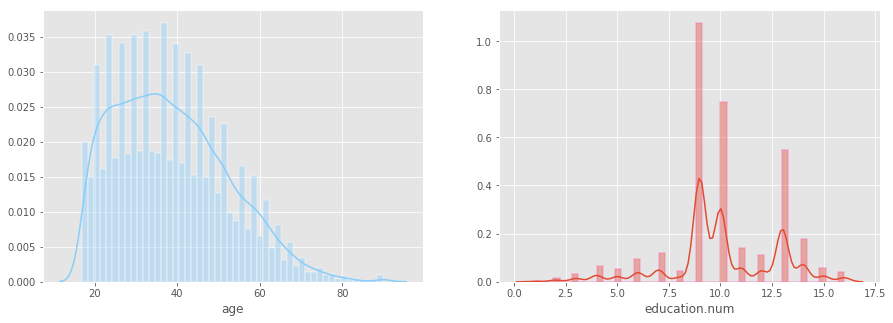

In [7]:
""" Categorical Distributions"""
fig,ax=plt.subplots(nrows=1, ncols=2,figsize=(15,5))
sns.distplot(df['age'],color='#87CEFA',hist_kws=dict(edgecolor="#F0F8FF", linewidth=1.5),ax=ax[0])
sns.distplot(df['education.num'],hist_kws=dict(edgecolor="#FF69B4", linewidth=1.5),ax=ax[1])

Text(0.5,1,'Gender and Race')

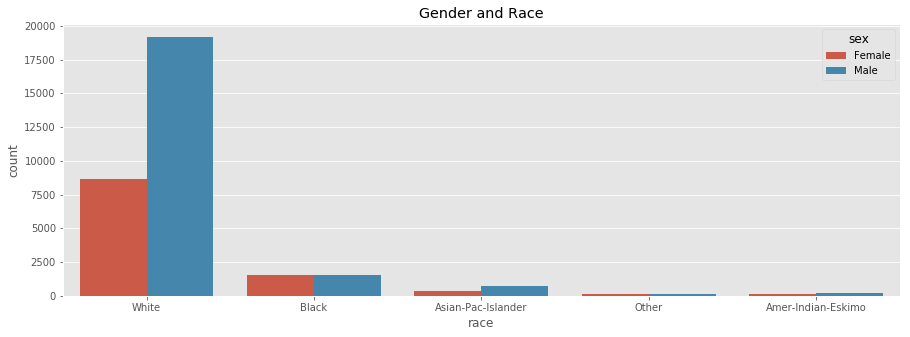

In [8]:
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(15,5))
sns.countplot(x='race',hue='sex',data=df).set_title("Gender and Race")

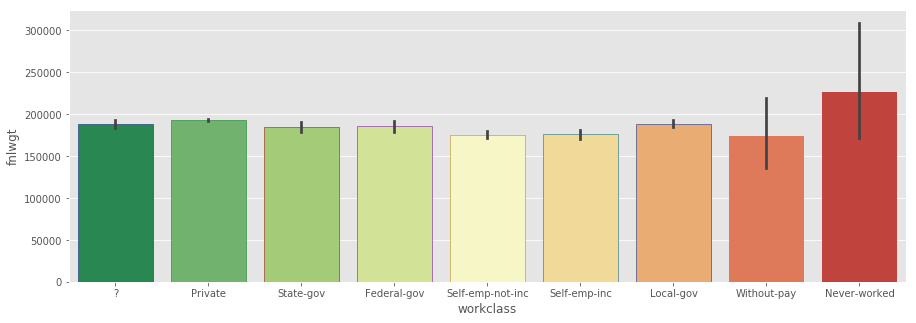

In [98]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
sns.barplot(x='workclass',y='fnlwgt',data=df,palette='RdYlGn_r',edgecolor=sns.color_palette('dark',7))

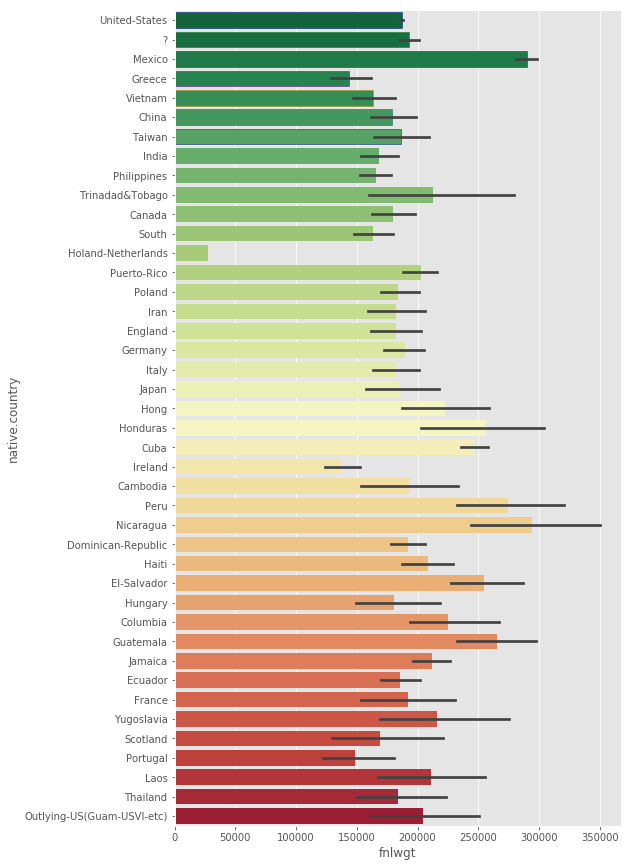

In [67]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,15)) #seaborn can deermine the orientation of the dataset (h or v) based on whether x or y is cat4gorical
sns.barplot(x='fnlwgt',y='native.country',data=df.loc[:,['native.country','fnlwgt']]
,palette='RdYlGn_r',edgecolor=sns.color_palette('dark',7))

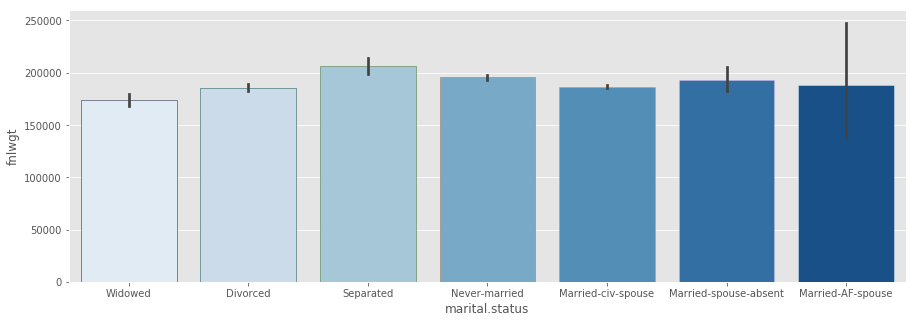

In [39]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
sns.barplot(x='marital.status',y='fnlwgt',data=df,palette='Blues',edgecolor=sns.color_palette('cubehelix',7))

In [24]:
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# df.loc[df['income']=='>50K',['race':'income']]
# plt.pie(df.loc[df['income']=='>50K',:], labels=df['race'])
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()

raceIncomeDf=df.loc[:,['race','income']]
genderIncomeDf=df.loc[:,['sex','income']]

over50k=lambda x: raceIncomeDf.loc[(raceIncomeDf['race']==x) & (raceIncomeDf['income']=='>50K'),:].shape[0]
below50k=lambda x: raceIncomeDf.loc[(raceIncomeDf['race']==x) & (raceIncomeDf['income']=='<=50K'),:].shape[0]

over50k_sex= lambda x: genderIncomeDf.loc[(genderIncomeDf['sex']==x) & (genderIncomeDf['income']=='>50K'),:].shape[0]
below50k_sex=lambda x: genderIncomeDf.loc[(genderIncomeDf['sex']==x) & (genderIncomeDf['income']=='<=50K'),:].shape[0]

totalRace= lambda x: df.loc[df['race']==x].shape[0] 
totalSex=lambda x: df.loc[df['sex']==x].shape[0] 

over50kProp=lambda x:(df.loc[(df['income']=='>50K') & (df['race']==x)].shape[0])*((100)/(df.loc[df['race']==x].shape[0]))
#ex: (df.loc[(df['income']=='>50K') & (df['race']=='White')].shape[0])*((100)/(df.loc[df['race']=='White'].shape[0]))
over50kProp_sex=lambda x:(df.loc[(df['income']=='>50K') & (df['sex']==x)].shape[0])*((100)/(df.loc[df['sex']==x].shape[0]))


raceSum=pd.DataFrame()
raceSum['race']=df['race'].unique()#white,black,etc
raceSum['>50k']=raceSum['race'].apply(over50k)
raceSum['<=50k']=raceSum['race'].apply(below50k)
raceSum['total']=raceSum['race'].apply(totalRace)
raceSum['>50kProp']=raceSum['race'].apply(over50kProp)

genderSum=pd.DataFrame() #gI: Gender Income
genderSum['sex']=df['sex'].unique()#male,female
genderSum['>50k']=genderSum['sex'].apply(over50k_sex)
genderSum['<=50k']=genderSum['sex'].apply(below50k_sex)
genderSum['total']=genderSum['sex'].apply(totalSex)
genderSum['>50kProp']=genderSum['sex'].apply(over50kProp_sex)


print('raceIncomeDf','\t','genderIncomeDf')
display_side_by_side(raceIncomeDf.head(3),genderIncomeDf.head(3))   
print('raceSum','\t\t\t\t\t','genderSum')
display_side_by_side(raceSum,genderSum)



raceIncomeDf 	 genderIncomeDf


,race,income
0,White,<=50K
1,White,<=50K
2,Black,<=50K
,sex,income
0,Female,<=50K
1,Female,<=50K
2,Female,<=50K


raceSum 					 genderSum


,race,>50k,<=50k,total,>50kProp
0,White,7117,20699,27816,25.585994
1,Black,387,2737,3124,12.387964
2,Asian-Pac-Islander,276,763,1039,26.564004
3,Other,25,246,271,9.225092
4,Amer-Indian-Eskimo,36,275,311,11.575563
,sex,>50k,<=50k,total,>50kProp
0,Female,1179,9592,10771,10.946059
1,Male,6662,15128,21790,30.573658


In [ ]:
"""Age Distribution by Race"""

Text(0.5,1,'Proportion of those making >50k by race')

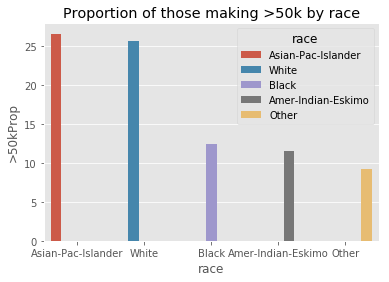

In [115]:
"""Income Distribution by Race"""
# sns.countplot(y='race',data=raceSum,hue='race').set_title("race and >50k") 
#countplot allows either x or y but not both
#remember: countplot requires 2 categorical variables as opposed to barplot (1 cat, 1 numeric via x and y)
sns.barplot(x='race',y='>50kProp',data=raceSum.sort_values('>50kProp',ascending=False),hue='race').set_title("Proportion of those making >50k by race") 



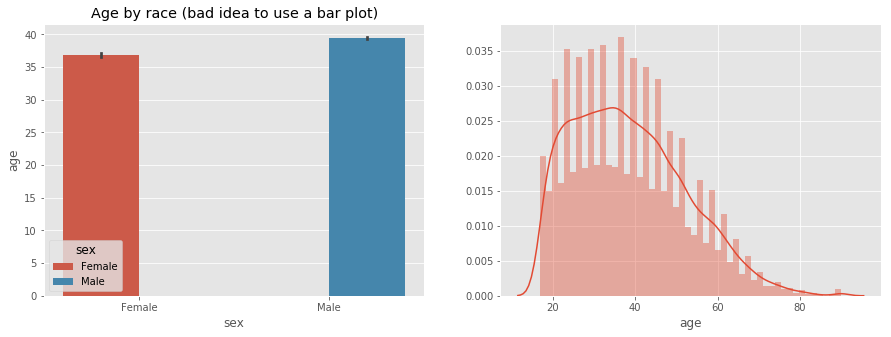

In [128]:
"""Age Distribution by sex""" #perfect use case for barplot (although many others are useful, but we just learned the difference between barplot and countplot)
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.barplot(x='sex',y='age',data=df,hue='sex',ax=ax[0]).set_title("Age by race (bad idea to use a bar plot)")
#in fact, barplot is not a good idea since there are many distinct ages, use a distplot instead
#(and btw, what is the difference between a kde and a distplot? kde is distplot with the histograms) 
"""
so then how do we view the distribution of age by race?:
    use a violin plot
    restrict the dataset to either race
    or stack
"""
sns.distplot(df['age'],ax=ax[1])

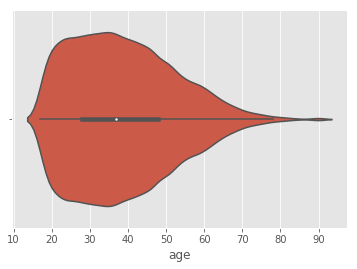

In [134]:
#how to view 'age distribution by race' side by side? (since kdes cannot be stacked, use a violin plot)
#violin plots can have an x & y unlike distplot. they're essentiallyy like distibutive bar pots
sns.violinplot(x='age',data=df,hue='race',split=True)
#not a good idea to use for race column since violinplots work well with only 2 categorical variables

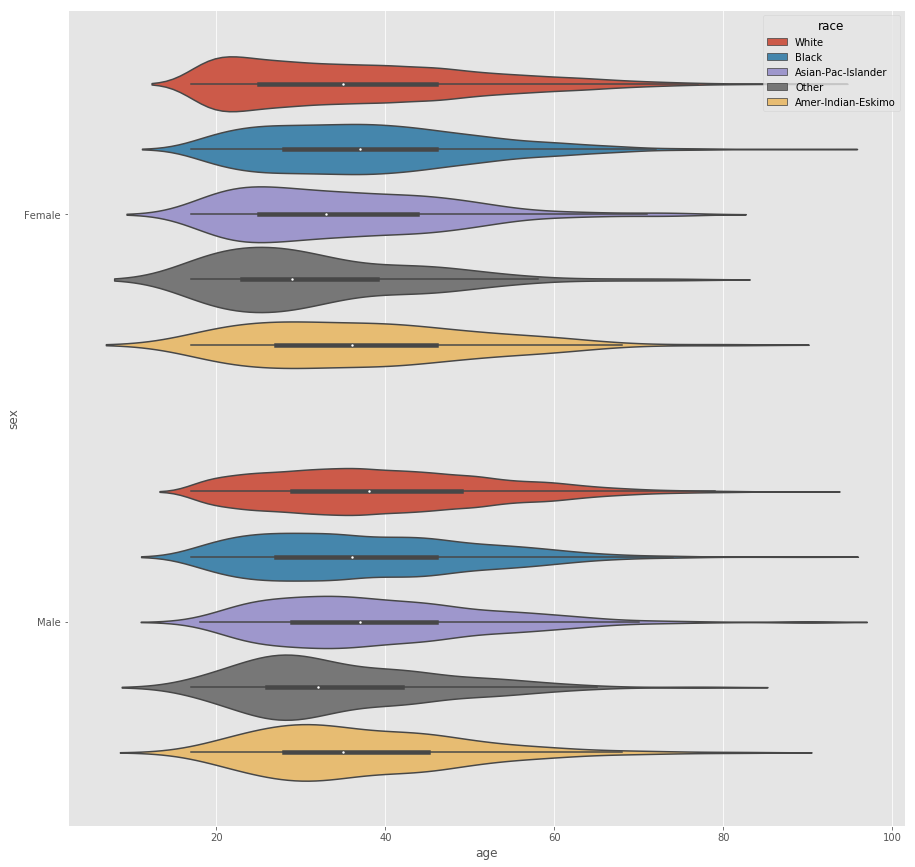

In [150]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,15))
sns.violinplot(x='age',y='sex',data=df,hue='race') #oh wow, violin plots seem to use 2 cat. variables and 1 continuous(that is if one wants to use split=True)
#not a good way to order data, since the distribution is not obvious

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,incomeCat
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,0
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K,0


"\nfunny thing: I just realized that the income column is already a 2-variable categorical column and did not need mapping\nhence\nsns.violinplot(x='age',y='sex',data=df,hue='income',split=True) is valid as well\ninner='quartile' : produces dotted lines in the plot\n"

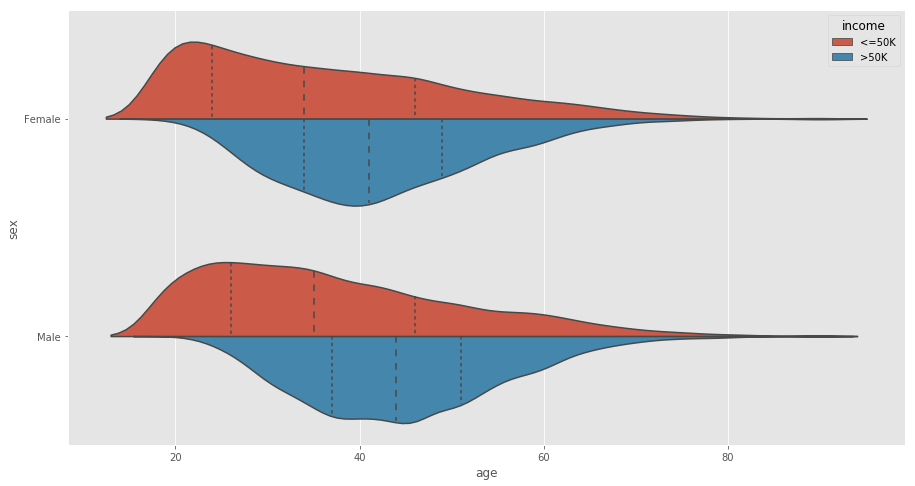

In [169]:
"""Age Distribution between men/women who make >50k and women who don't (by race)"""
#since the income column is not categorical, we will need to make a categoircal column (and possibly drop it later)
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,8))
def incomeMappingLambda(x):
    category='0'
    if(x=='>50K'): #note 'K' not 'k' in 50K
        category='1'
    return category

df['incomeCat']=df['income'].apply(incomeMappingLambda).astype(str)
display(df.head(3))
#we can now use a violin plot since we have another 2-variable categorical column
sns.violinplot(x='age',y='sex',data=df,hue='income',inner = 'quartile',split=True)#and now we can use split=True
"""
funny thing: I just realized that the income column is already a 2-variable categorical column and did not need mapping
hence
sns.violinplot(x='age',y='sex',data=df,hue='income',split=True) is valid as well
inner='quartile' : produces dotted lines in the plot
"""

"""
tbh the violin plot is not as indicative as I would like it to be so i'll use
a plot where several density plots are used on the same graph
"""

"\nnote that with this method, the plots scale relative to one another.\ncomment out some of the 'sns.kdeplot' and see what happens.\nHence for this method, it is best that one uses data that have similar distribution \n(see what happens when 'sns.kdeplot(df['capital.gain'])' is uncommented )\n"

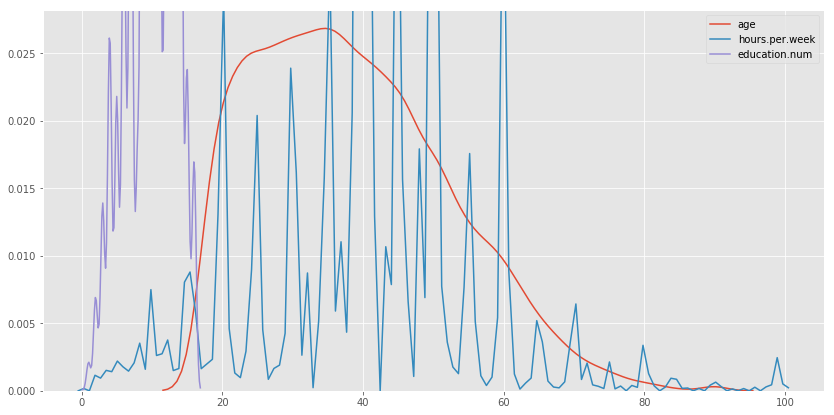

In [188]:
#to plot several densite plots on the same figure
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(14,7)) #define fig,ax with nrows=1 and ncols=1
#then continue creating plots
sns.kdeplot(df['age'])
sns.kdeplot(df['hours.per.week'])
sns.kdeplot(df['education.num'])
#sns.kdeplot(df['capital.gain']) #uncomment and see what happens
"""
note that with this method, the plots scale relative to one another.
comment out some of the 'sns.kdeplot' and see what happens.
Hence for this method, it is best that one uses data that have similar distribution 
(see what happens when 'sns.kdeplot(df['capital.gain'])' is uncommented ).
How does one determine what columns(or features) have the same distributions?
"""

In [ ]:
"""Income Distribution by Gender"""

Age Column

In [ ]:
fig,ax=plt.subplots(nrows=1, ncols=2,figsize=(15,5))
sns.distplot(df['age'],bins=20,hist_kws=dict(edgecolor="#F0F8FF", linewidth=1.5),ax=ax[0])
#df['age'].isnull.sum().plot(kind='pie',ax=ax[1])#2 ways to plot pie charts and needs an index for grouping

series = pd.Series(3 * np.random.rand(2),
                   index=['age','work class'], 
                   name='null entries')
"""
one way to avoid the problem with pieplots is to simply create a series
and plot, as seen in the dataset

df['age'].isnull().sum(), 
                   df['workclass'].isnull().sum()
"""
series.plot.pie()